## 範例 : (Kaggle)房價預測

## [教學目標]

用房價預測資料, 觀察填補缺值以及 標準化 / 最小最大化 對數值的影響

## [範例重點]

知道如何查詢各欄位空缺值數量 (In[2], Out[2])

觀察替換不同補缺方式, 對於特徵的影響 (In[5]~In[7], Out[5]~Out[7])

觀察替換不同特徵縮放方式, 對於特徵的影響 (In[8]~In[9], Out[8]~Out[9])

In [1]:
# 載入套件
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

# 讀取訓練與測試資料
data_path = '/Users/johnsonhuang/py_ds/ML_100/2nd-ML100Days/homework/data/Part02/'
df_train = pd.read_csv(data_path + 'house_train.csv.gz')
df_test = pd.read_csv(data_path + 'house_test.csv.gz')

# 重組資料成為訓練 / 預測用格式
train_Y = np.log1p(df_train['SalePrice'])
ids = df_test['Id']
df_train = df_train.drop(['Id', 'SalePrice'] , axis=1)
df_test = df_test.drop(['Id'] , axis=1)
df = pd.concat([df_train,df_test])
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [2]:
# 檢查欄位缺值數量 (去掉.head()可以顯示全部)
df.isnull().sum().sort_values(ascending=False).head()

PoolQC         2909
MiscFeature    2814
Alley          2721
Fence          2348
FireplaceQu    1420
dtype: int64

In [3]:
#只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)
print(f'{len(num_features)} Numeric Features : {num_features}\n')

36 Numeric Features : ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']



In [4]:
# 削減文字型欄位, 只剩數值型欄位
df = df[num_features]
train_num = train_Y.shape[0]
df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,548.0,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,460.0,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,608.0,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,642.0,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,836.0,192,84,0,0,0,0,0,12,2008


In [5]:
# 空值補 -1, 做線性迴歸
df_m1 = df.fillna(-1)
train_X = df_m1[:train_num]
estimator = LinearRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8466400643386487

In [6]:
# 空值補 0
df_0 = df.fillna(0)
train_X = df_0[:train_num]
estimator = LinearRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8466118155868754

In [7]:
# 空值補平均值
df_mn = df.fillna(df.mean())
train_X = df_mn[:train_num]
estimator = LinearRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.844264243220125

In [8]:
# 空值補 -1, 搭配最大最小化
df = df.fillna(-1)
df_temp = MinMaxScaler().fit_transform(df)
train_X = df_temp[:train_num]
estimator = LinearRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8469086492942719

In [9]:
# 搭配標準化
df_temp = StandardScaler().fit_transform(df)
train_X = df_temp[:train_num]
estimator = LinearRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8466610059332084

## 作業 : [(Kaggle)鐵達尼生存預測](https://www.kaggle.com/c/titanic)

## [作業目標]

試著模仿範例寫法, 在鐵達尼生存預測中, 觀察填補缺值以及 標準化 / 最小最大化 對數值的影響

## [作業重點]

觀察替換不同補缺方式, 對於特徵的影響 (In[4]~In[6], Out[4]~Out[6])

觀察替換不同特徵縮放方式, 對於特徵的影響 (In[7]~In[8], Out[7]~Out[8])

In [10]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

data_path = '/Users/johnsonhuang/py_ds/ML_100/2nd-ML100Days/homework/data/Part02/'
df_train = pd.read_csv(data_path + 'titanic_train.csv')
df_test = pd.read_csv(data_path + 'titanic_test.csv')

train_Y = df_train['Survived']
ids = df_test['PassengerId']
df_train = df_train.drop(['PassengerId', 'Survived'] , axis=1)
df_test = df_test.drop(['PassengerId'] , axis=1)
df = pd.concat([df_train,df_test])
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
#只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)
print(f'{len(num_features)} Numeric Features : {num_features}\n')

5 Numeric Features : ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']



In [12]:
# 削減文字型欄位, 只剩數值型欄位
df = df[num_features]
train_num = train_Y.shape[0]
df.head()

,Pclass,Age,SibSp,Parch,Fare
0,3,22.0,1,0,7.2500
1,1,38.0,1,0,71.2833
2,3,26.0,0,0,7.9250
3,1,35.0,1,0,53.1000
4,3,35.0,0,0,8.0500


## 作業1

試著在補空值區塊, 替換並執行兩種以上填補的缺值, 看看何者比較好?

In [13]:
# 空值補 -1, 做羅吉斯迴歸
df_m1 = df.fillna(-1)
train_X = df_m1[:train_num]
estimator = LogisticRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.6960299128976762

In [14]:
# 空值補 0, 做羅吉斯迴歸
df_0 = df.fillna(0)
train_X = df_0[:train_num]
estimator = LogisticRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.6971535084032942

In [15]:
# 空值補平均值, 做羅吉斯迴歸
df_mn = df.fillna(df.mean())
train_X = df_mn[:train_num]
estimator = LogisticRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.6981761033723469

In [16]:
# 空值補中位數, 做羅吉斯迴歸
df_me = df.fillna(df.median())
train_X = df_me[:train_num]
estimator = LogisticRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.6992934218081011

## 作業2

使用不同的標準化方式 ( 原值 / 最小最大化 / 標準化 )，搭配羅吉斯迴歸模型，何者效果最好?

In [17]:
# 空值補 -1, 原值, 做羅吉斯迴歸
df = df.fillna(-1)
train_X = df[:train_num]
estimator = LogisticRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.6960299128976762

In [18]:
# 空值補 -1, 搭配最大最小化, 做羅吉斯迴歸
df = df.fillna(-1)
df_temp = MinMaxScaler().fit_transform(df)
train_X = df_temp[:train_num]
estimator = LogisticRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.6971346062663598

In [19]:
# 空值補 -1, 搭配標準化, 做羅吉斯迴歸
df = df.fillna(-1)
df_temp = StandardScaler().fit_transform(df)
train_X = df_temp[:train_num]
estimator = LogisticRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.6982582017719778

In [20]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

data_path = '/Users/johnsonhuang/py_ds/ML_100/2nd-ML100Days/homework/data/Part02/'
df_train = pd.read_csv(data_path + 'titanic_train.csv')
df_test = pd.read_csv(data_path + 'titanic_test.csv')

train_Y = df_train['Survived']
ids = df_test['PassengerId']
df_train = df_train.drop(['PassengerId', 'Survived'] , axis=1)
df_test = df_test.drop(['PassengerId'] , axis=1)
df = pd.concat([df_train,df_test])
# 削減文字型欄位, 只剩數值型欄位
df = df[num_features]
# train, test 的分界點
train_num = train_Y.shape[0]


# make an empty df to save the result
score = pd.DataFrame(columns=["fill","scaler","score"])
for fill, scaler in [(f,s) for f in [(-1,"-1"), (0, "0"), (df.mean(),"mean"), (df.median(),"median")] for s in [(MinMaxScaler,"MinMaxScaler"), (StandardScaler,"StandardScaler"), (None,"None")]]:
    # make a copy
    df_copy = df.copy()
    
    # fillna
    df_temp = df_copy.fillna(fill[0])
    train_X = df_temp[:train_num]
    
    # Scaler
    if scaler[0]:
        s = scaler[0]()
        df_copy = df_copy.fillna(fill[0])
        df_temp = s.fit_transform(df_copy)
        train_X = df_temp[:train_num]
        
    estimator = LogisticRegression()
    score = score.append(pd.DataFrame([[fill[1],scaler[1],cross_val_score(estimator, train_X, train_Y, cv=5).mean()]],columns=["fill","scaler","score"]),ignore_index=True)
score.sort_values("fill")


,fill,scaler,score
0,-1,MinMaxScaler,0.697135
1,-1,StandardScaler,0.698258
2,-1,None,0.696030
3,0,MinMaxScaler,0.701629
4,0,StandardScaler,0.698258
5,0,None,0.697154
6,mean,MinMaxScaler,0.699350
7,mean,StandardScaler,0.695941
8,mean,None,0.698176
9,median,MinMaxScaler,0.698233


In [21]:
for fill, scaler in [(f,s) for f in [(-1,"-1"), (0, "0"), (df.mean(),"mean"), (df.median(),"median")] for s in [(MinMaxScaler,"MinMaxScaler"), (StandardScaler,"StandardScaler"), (None,"None")]]:
    print(fill)
    print(scaler)


(-1, '-1')
(<class 'sklearn.preprocessing.data.MinMaxScaler'>, 'MinMaxScaler')
(-1, '-1')
(<class 'sklearn.preprocessing.data.StandardScaler'>, 'StandardScaler')
(-1, '-1')
(None, 'None')
(0, '0')
(<class 'sklearn.preprocessing.data.MinMaxScaler'>, 'MinMaxScaler')
(0, '0')
(<class 'sklearn.preprocessing.data.StandardScaler'>, 'StandardScaler')
(0, '0')
(None, 'None')
(Pclass     2.294882
Age       29.881138
SibSp      0.498854
Parch      0.385027
Fare      33.295479
dtype: float64, 'mean')
(<class 'sklearn.preprocessing.data.MinMaxScaler'>, 'MinMaxScaler')
(Pclass     2.294882
Age       29.881138
SibSp      0.498854
Parch      0.385027
Fare      33.295479
dtype: float64, 'mean')
(<class 'sklearn.preprocessing.data.StandardScaler'>, 'StandardScaler')
(Pclass     2.294882
Age       29.881138
SibSp      0.498854
Parch      0.385027
Fare      33.295479
dtype: float64, 'mean')
(None, 'None')
(Pclass     3.0000
Age       28.0000
SibSp      0.0000
Parch      0.0000
Fare      14.4542
dtype: fl

In [22]:
for fill, scaler in [(f,s) for f in [(-1,"-1"), (0, "0"), (df.mean(),"mean"), (df.median(),"median")] for s in [(MinMaxScaler,"MinMaxScaler"), (StandardScaler,"StandardScaler"), (None,"None")]]:
    print(fill[0])
    df_temp = df.fillna(fill[0])
    train_X = df_temp[:train_num]
    if scaler[0]:
        print(scaler[0])


-1
<class 'sklearn.preprocessing.data.MinMaxScaler'>
-1
<class 'sklearn.preprocessing.data.StandardScaler'>
-1
0
<class 'sklearn.preprocessing.data.MinMaxScaler'>
0
<class 'sklearn.preprocessing.data.StandardScaler'>
0
Pclass     2.294882
Age       29.881138
SibSp      0.498854
Parch      0.385027
Fare      33.295479
dtype: float64
<class 'sklearn.preprocessing.data.MinMaxScaler'>
Pclass     2.294882
Age       29.881138
SibSp      0.498854
Parch      0.385027
Fare      33.295479
dtype: float64
<class 'sklearn.preprocessing.data.StandardScaler'>
Pclass     2.294882
Age       29.881138
SibSp      0.498854
Parch      0.385027
Fare      33.295479
dtype: float64
Pclass     3.0000
Age       28.0000
SibSp      0.0000
Parch      0.0000
Fare      14.4542
dtype: float64
<class 'sklearn.preprocessing.data.MinMaxScaler'>
Pclass     3.0000
Age       28.0000
SibSp      0.0000
Parch      0.0000
Fare      14.4542
dtype: float64
<class 'sklearn.preprocessing.data.StandardScaler'>
Pclass     3.0000
Age 

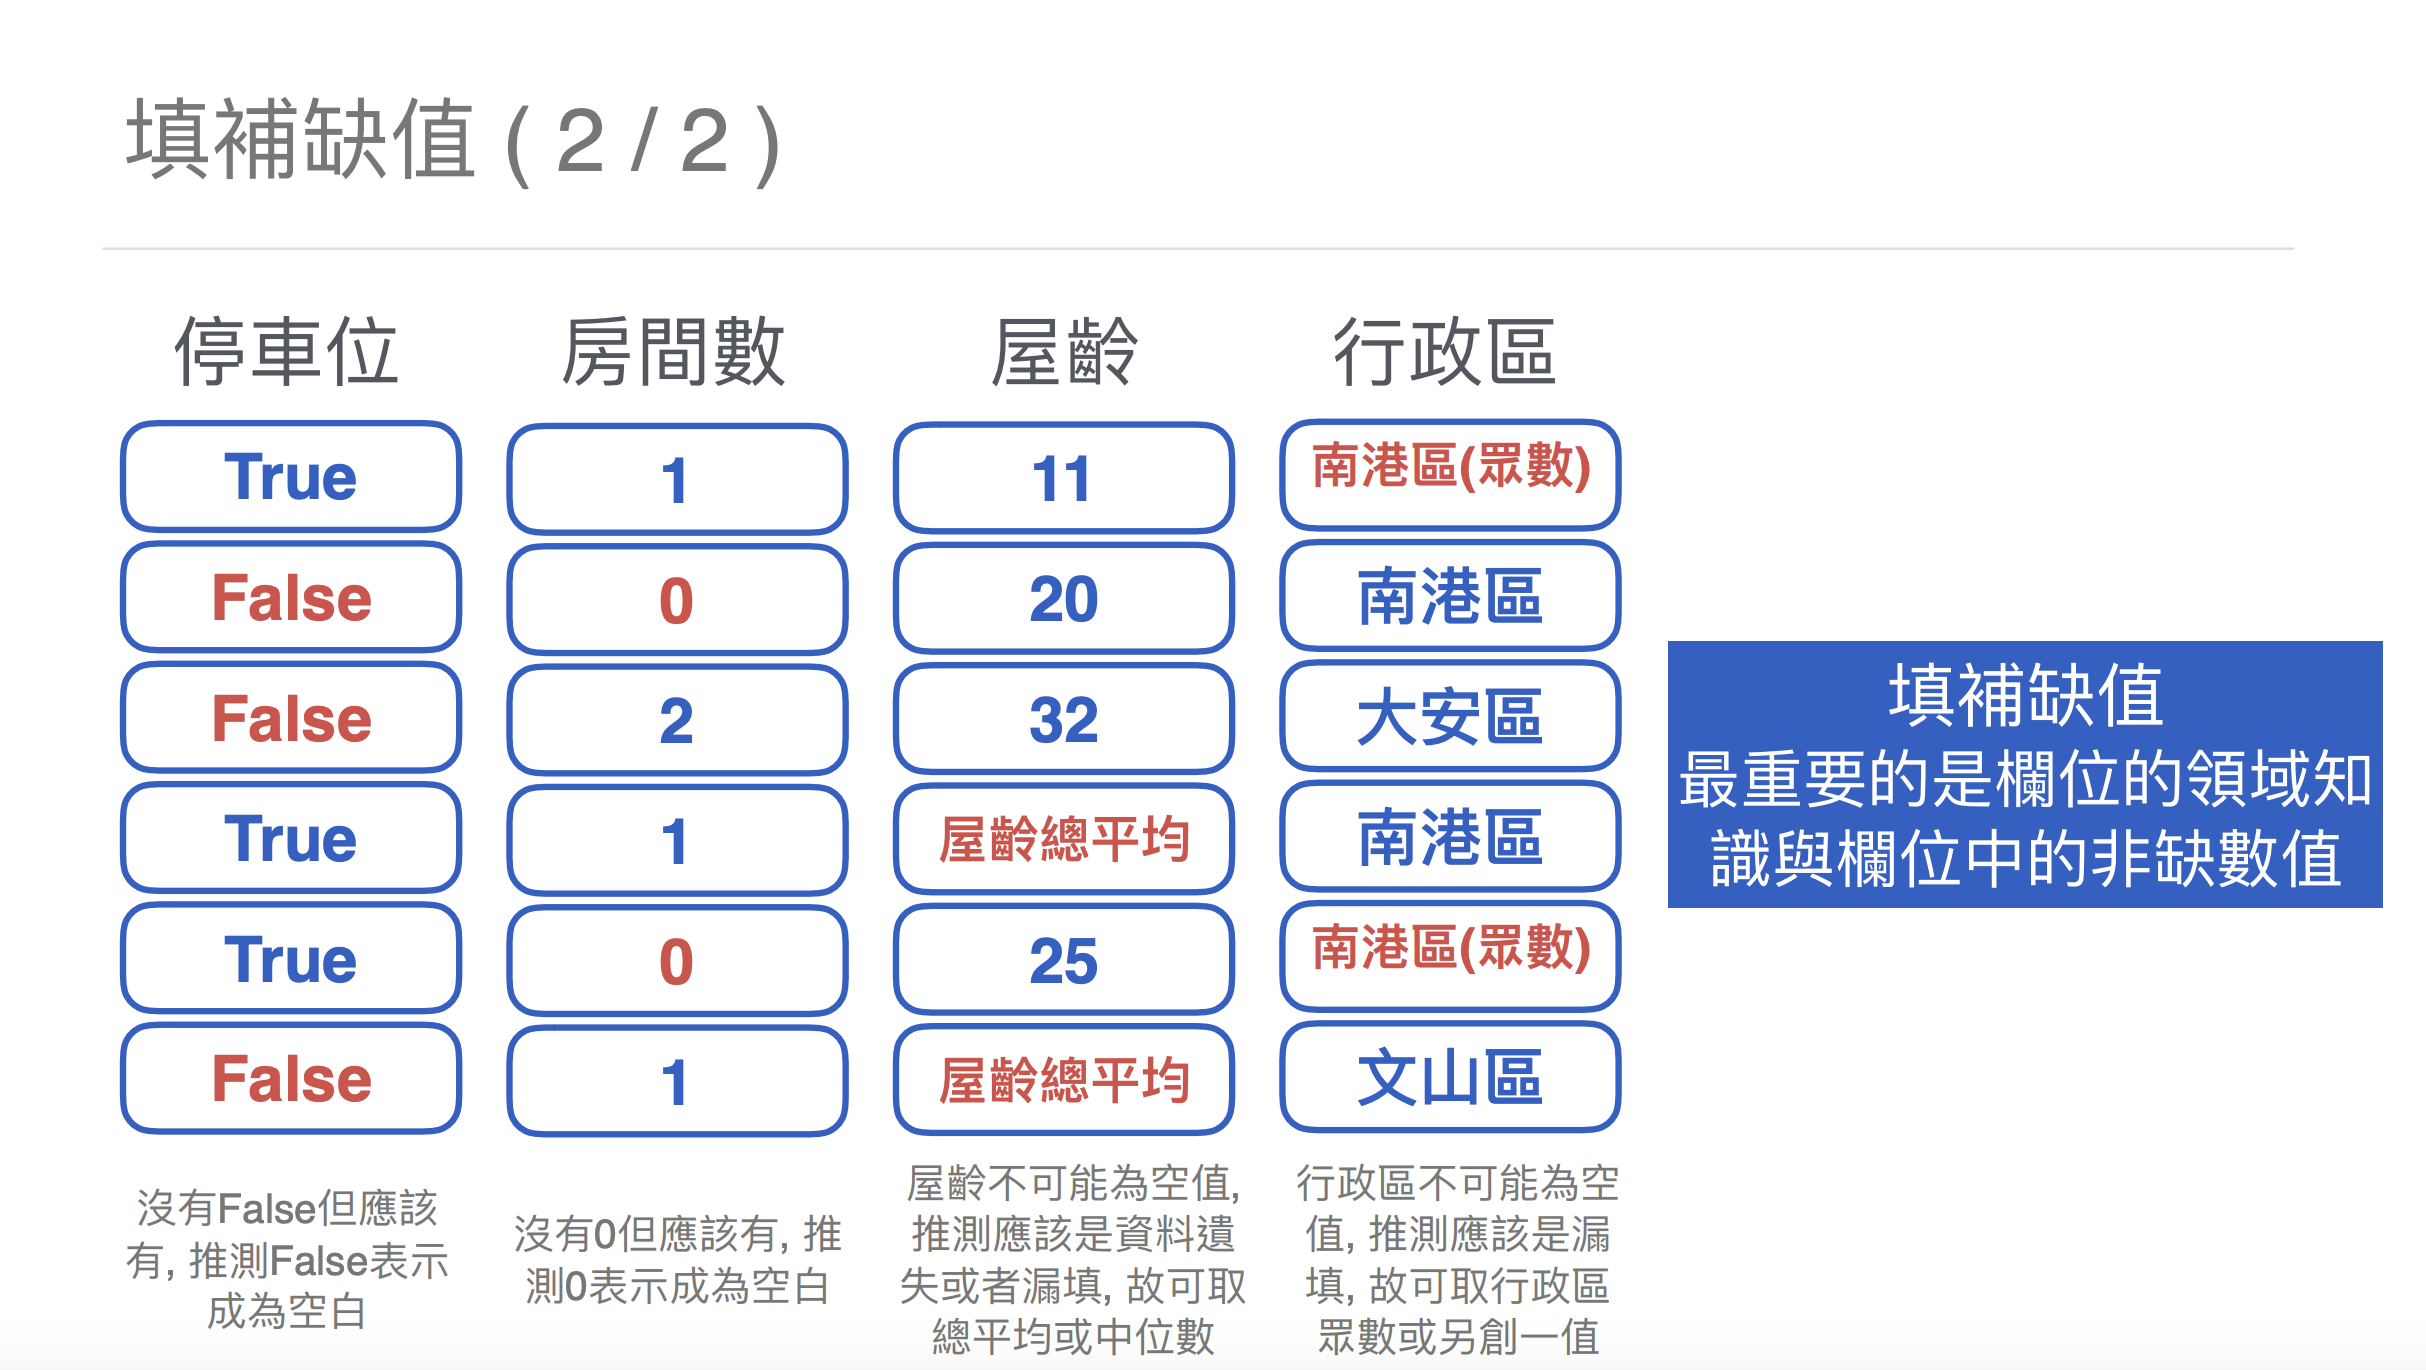

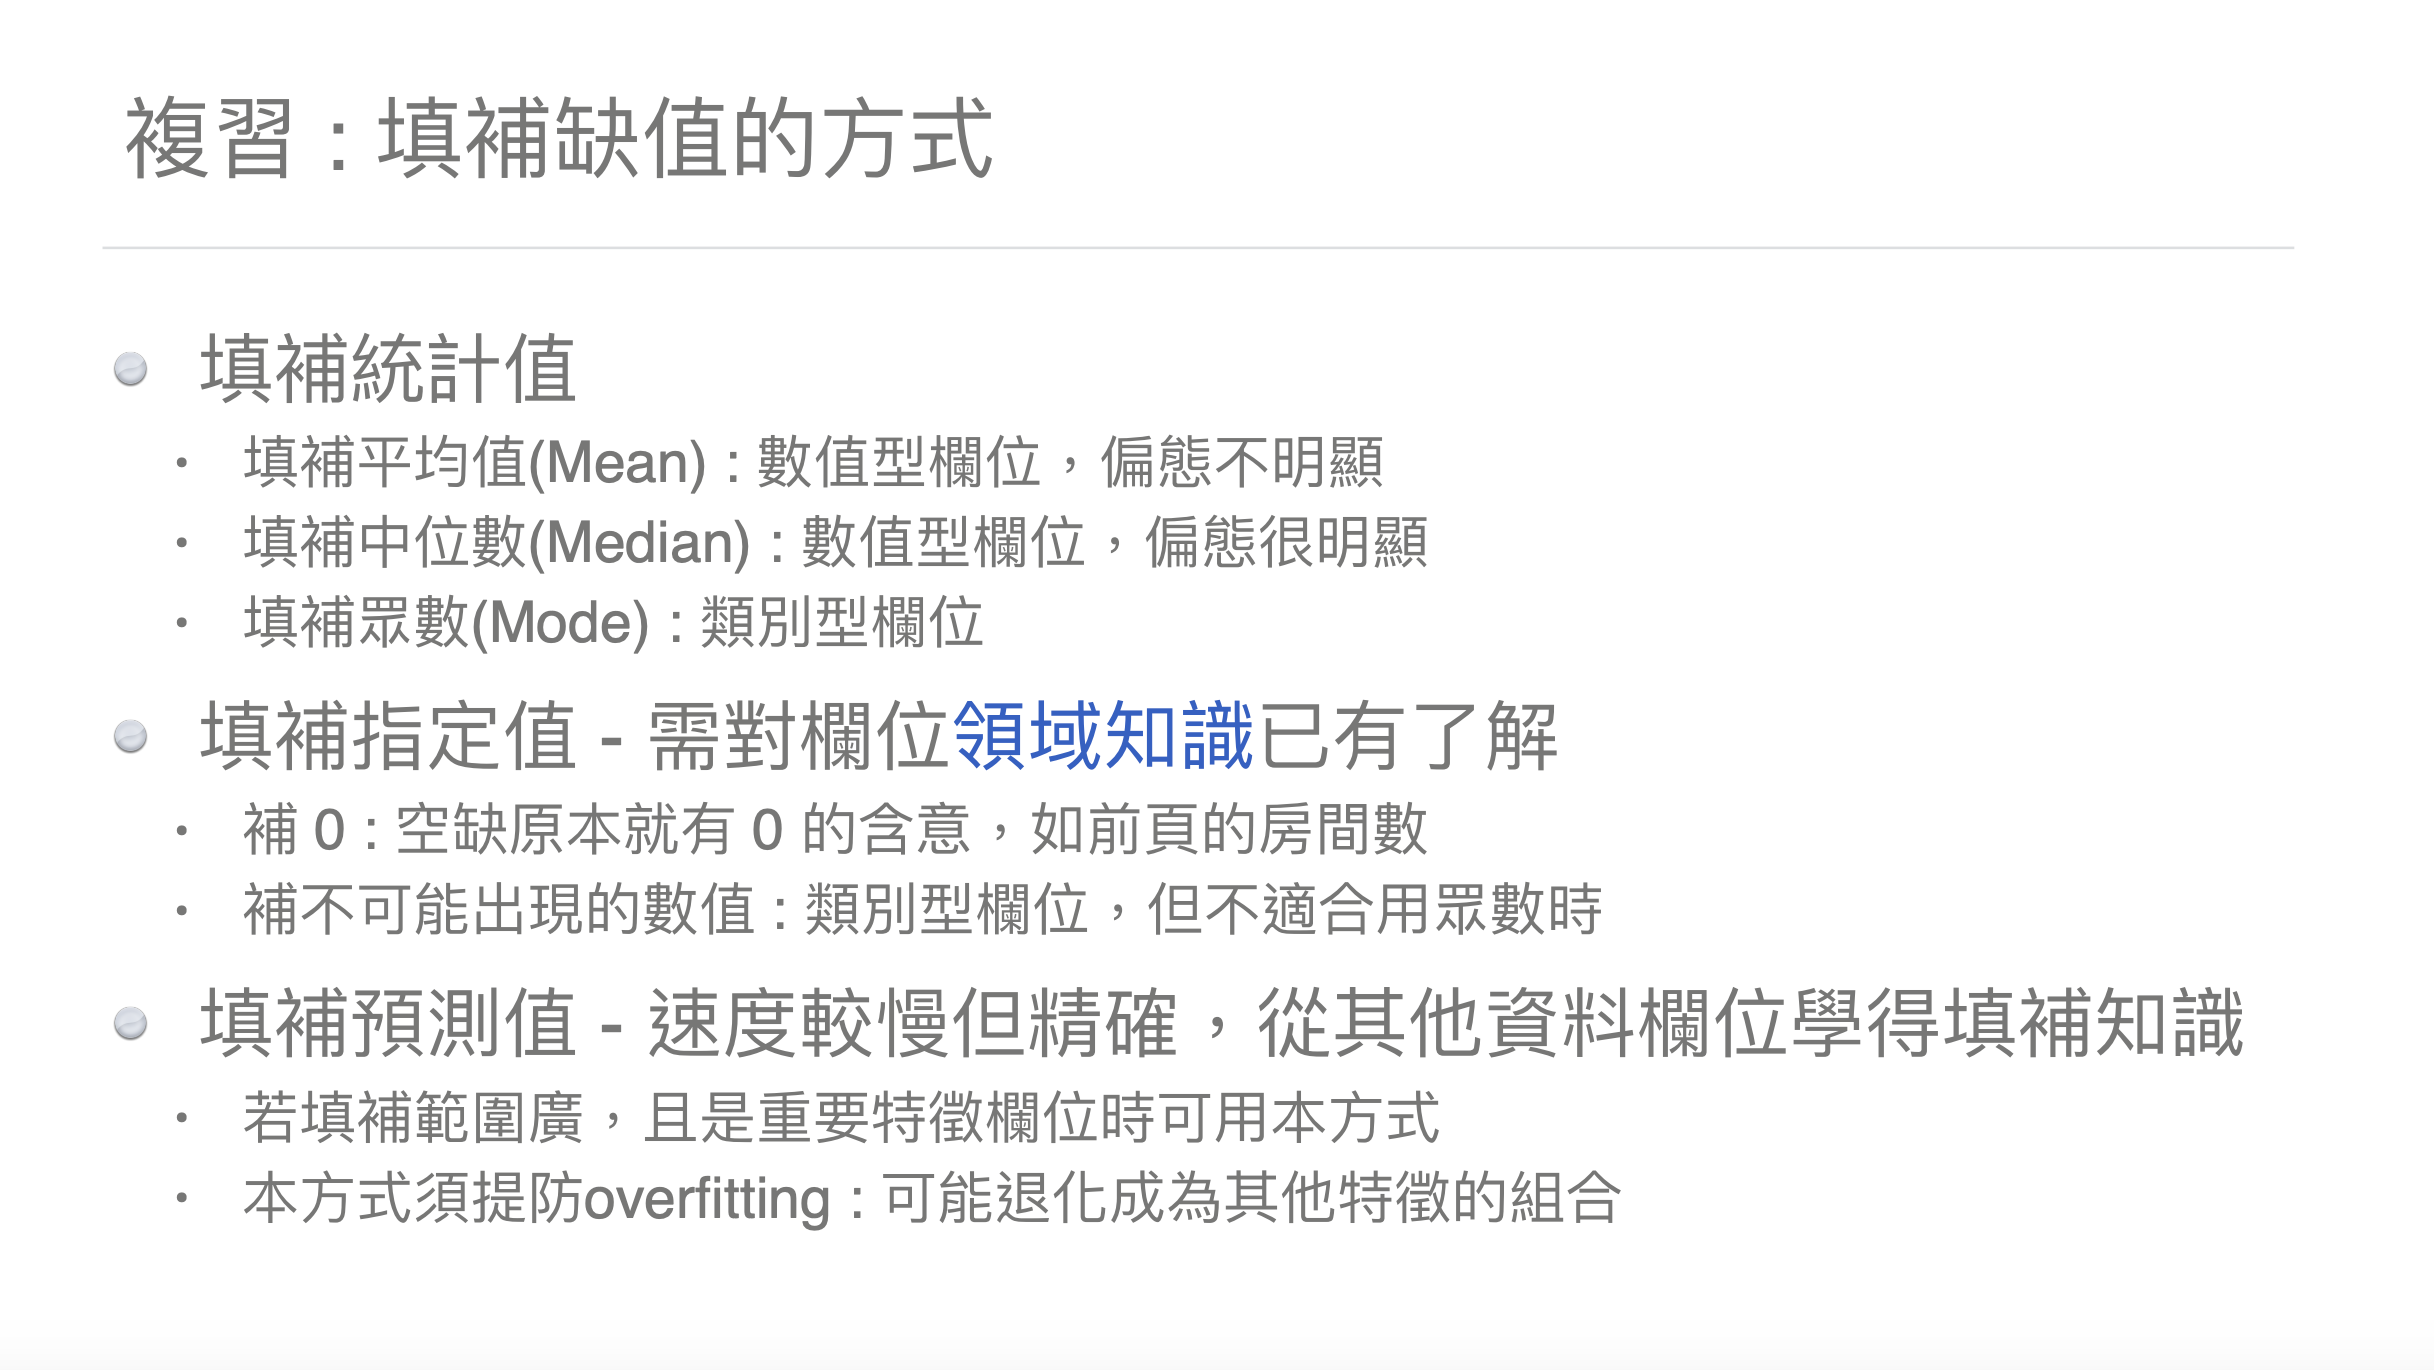

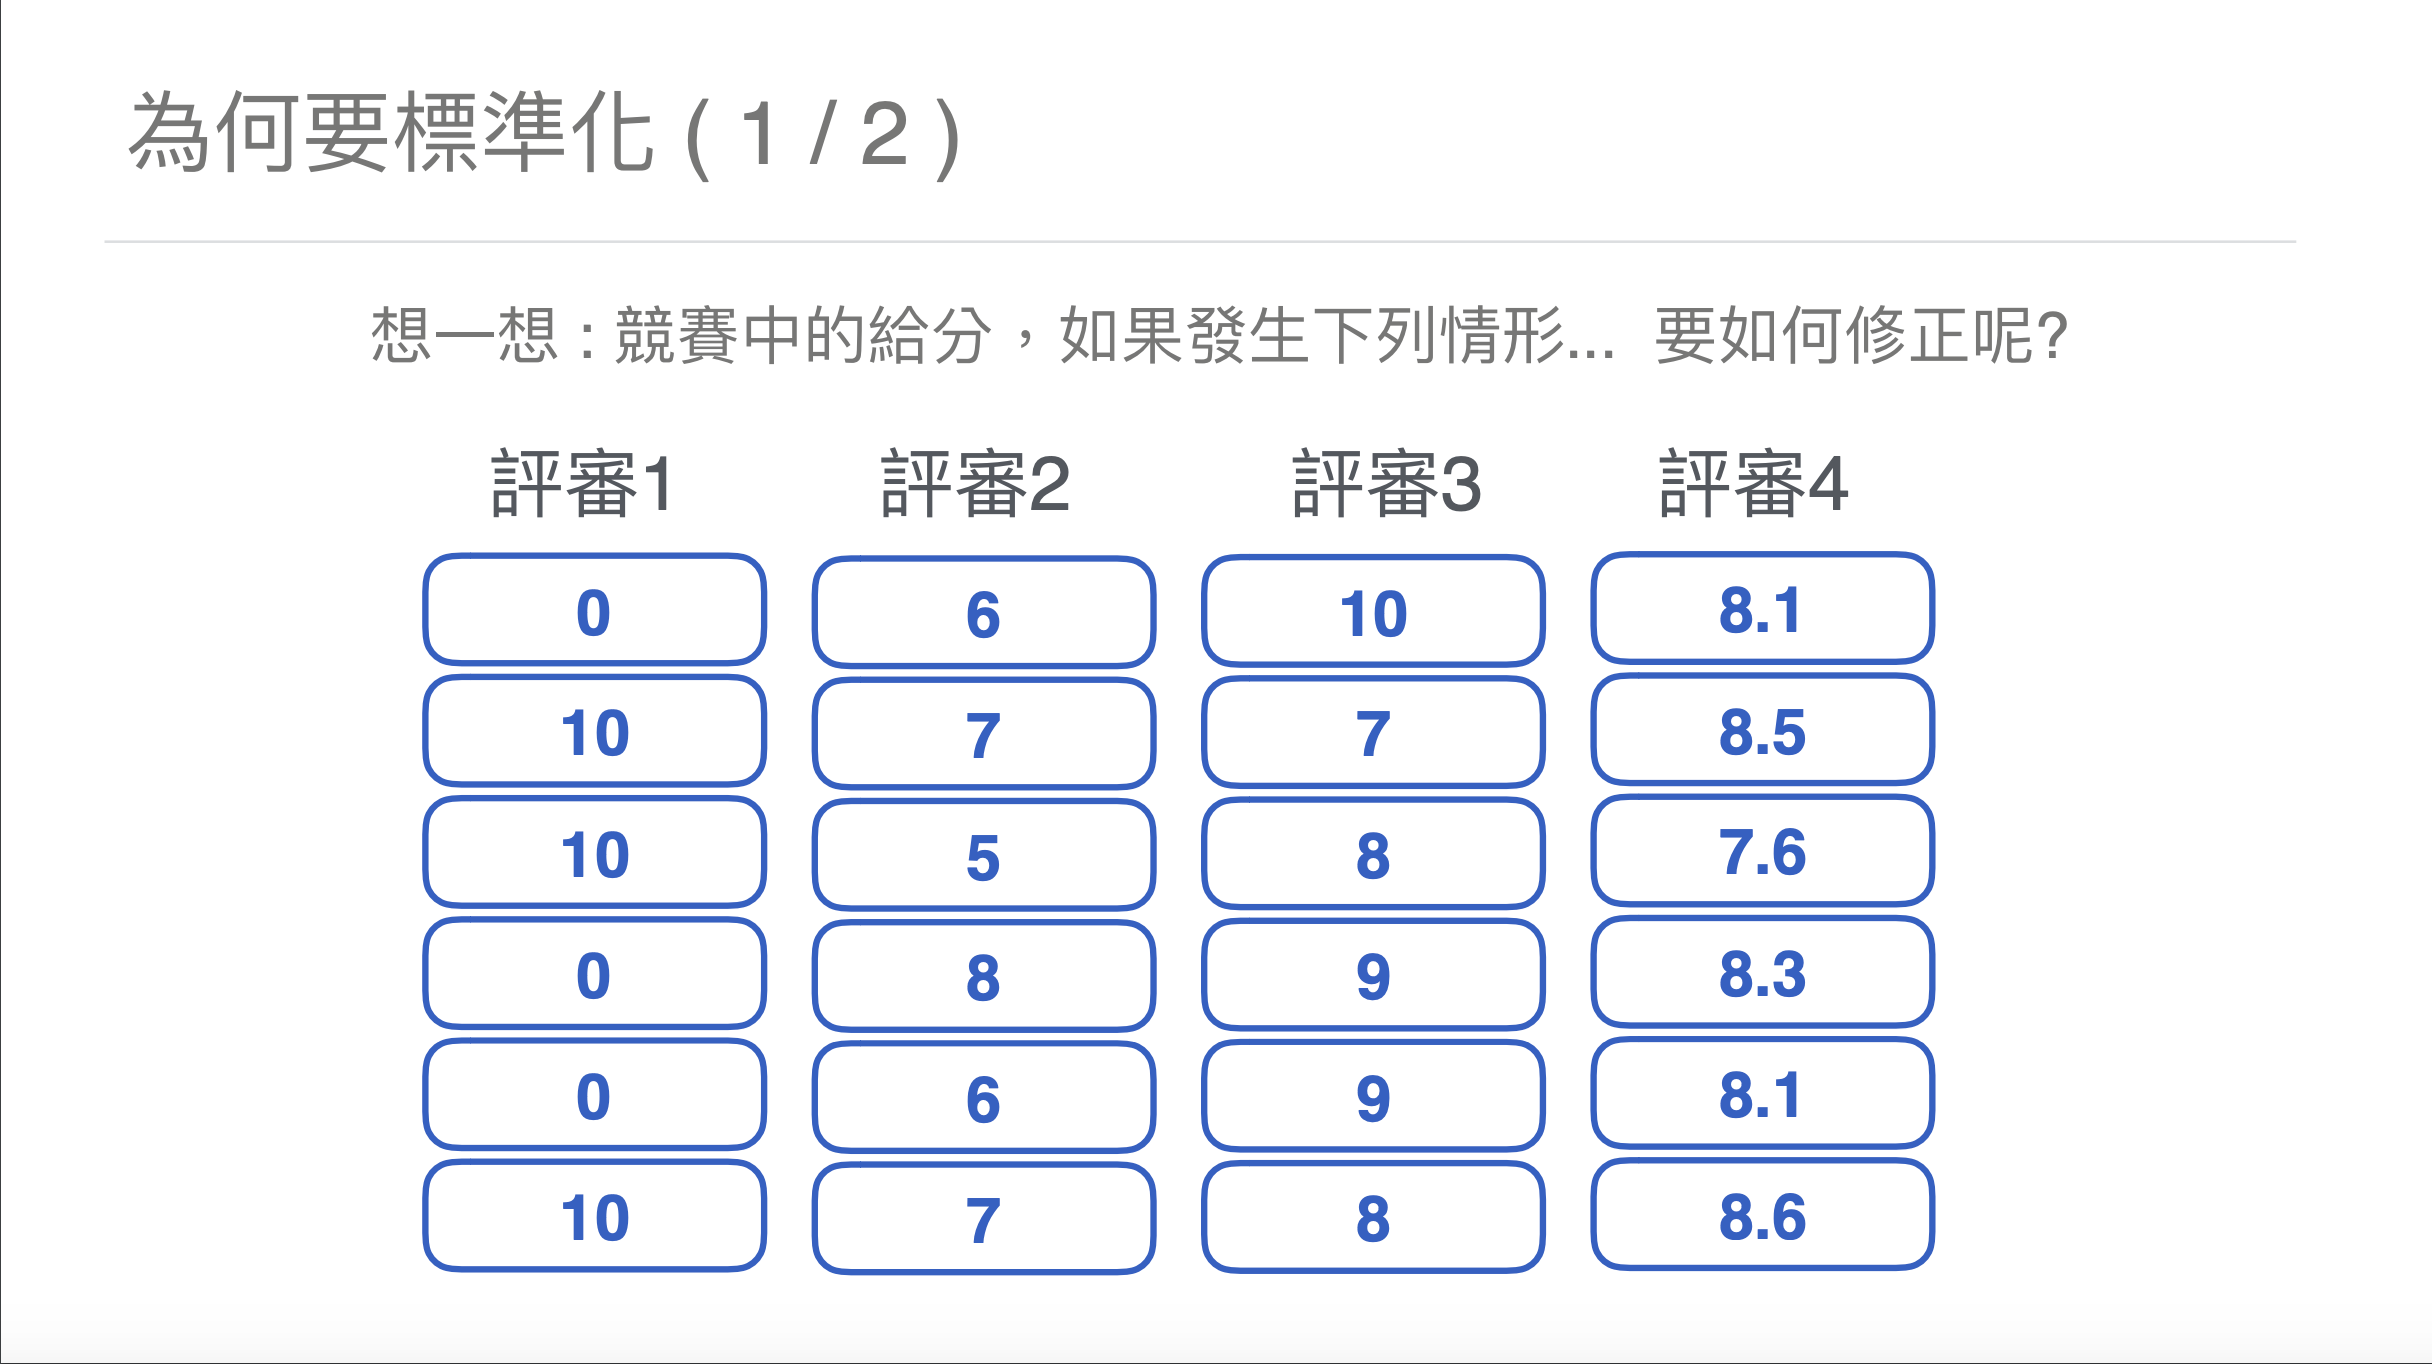

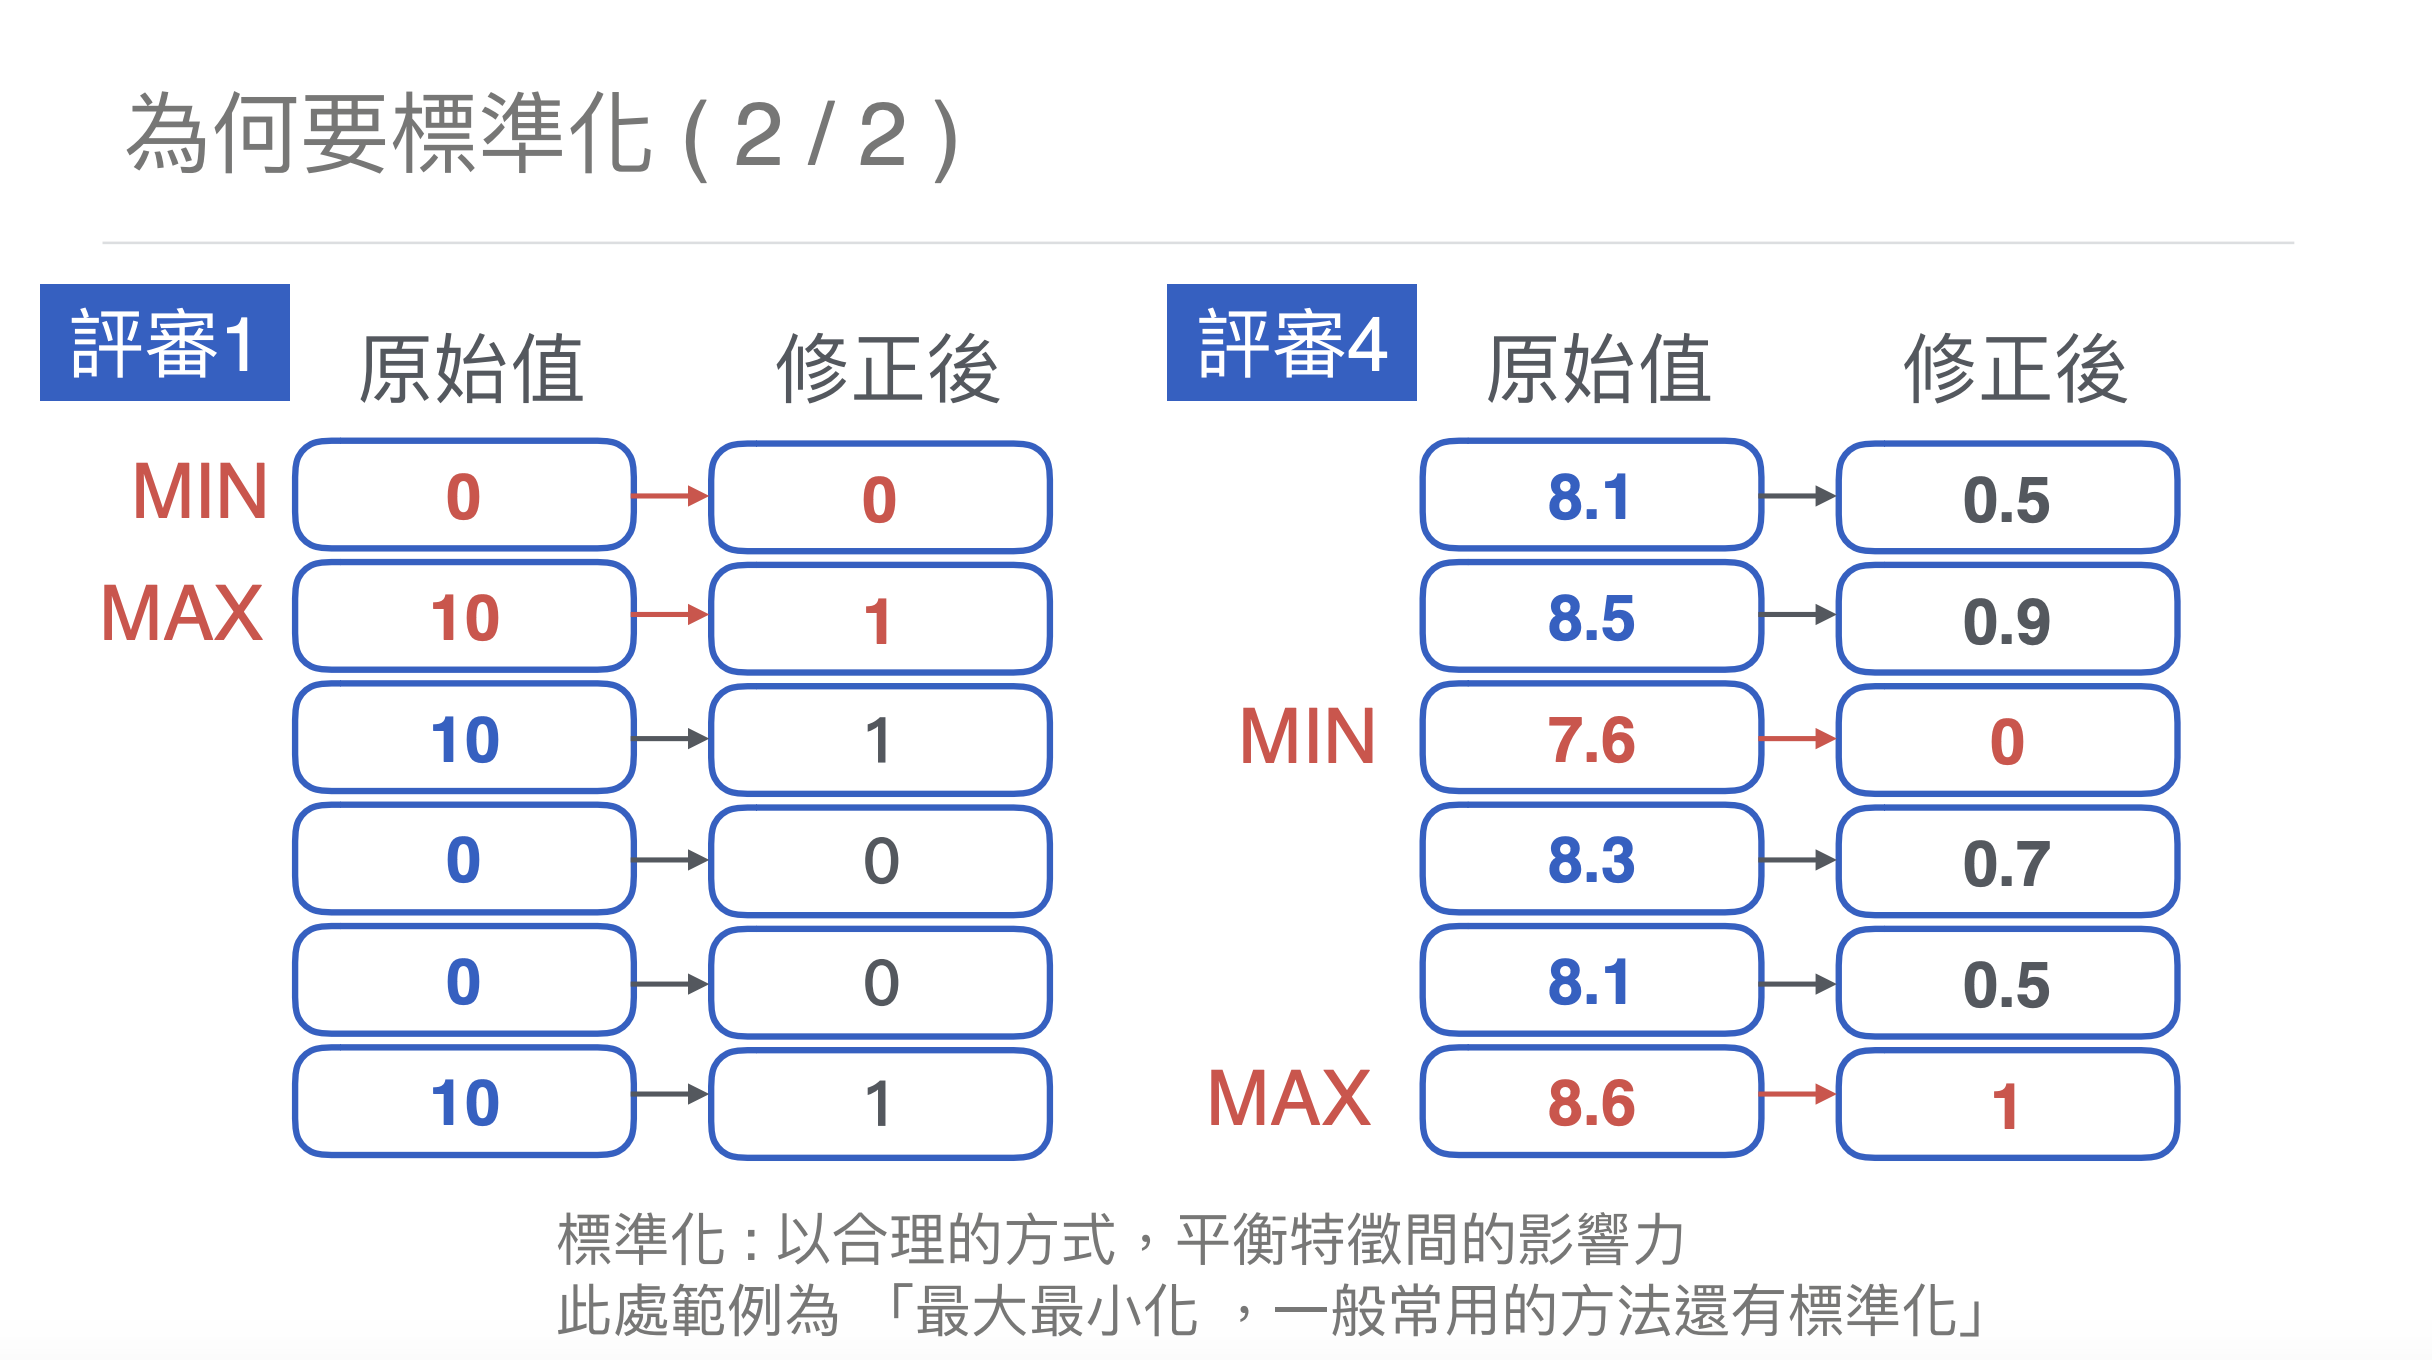

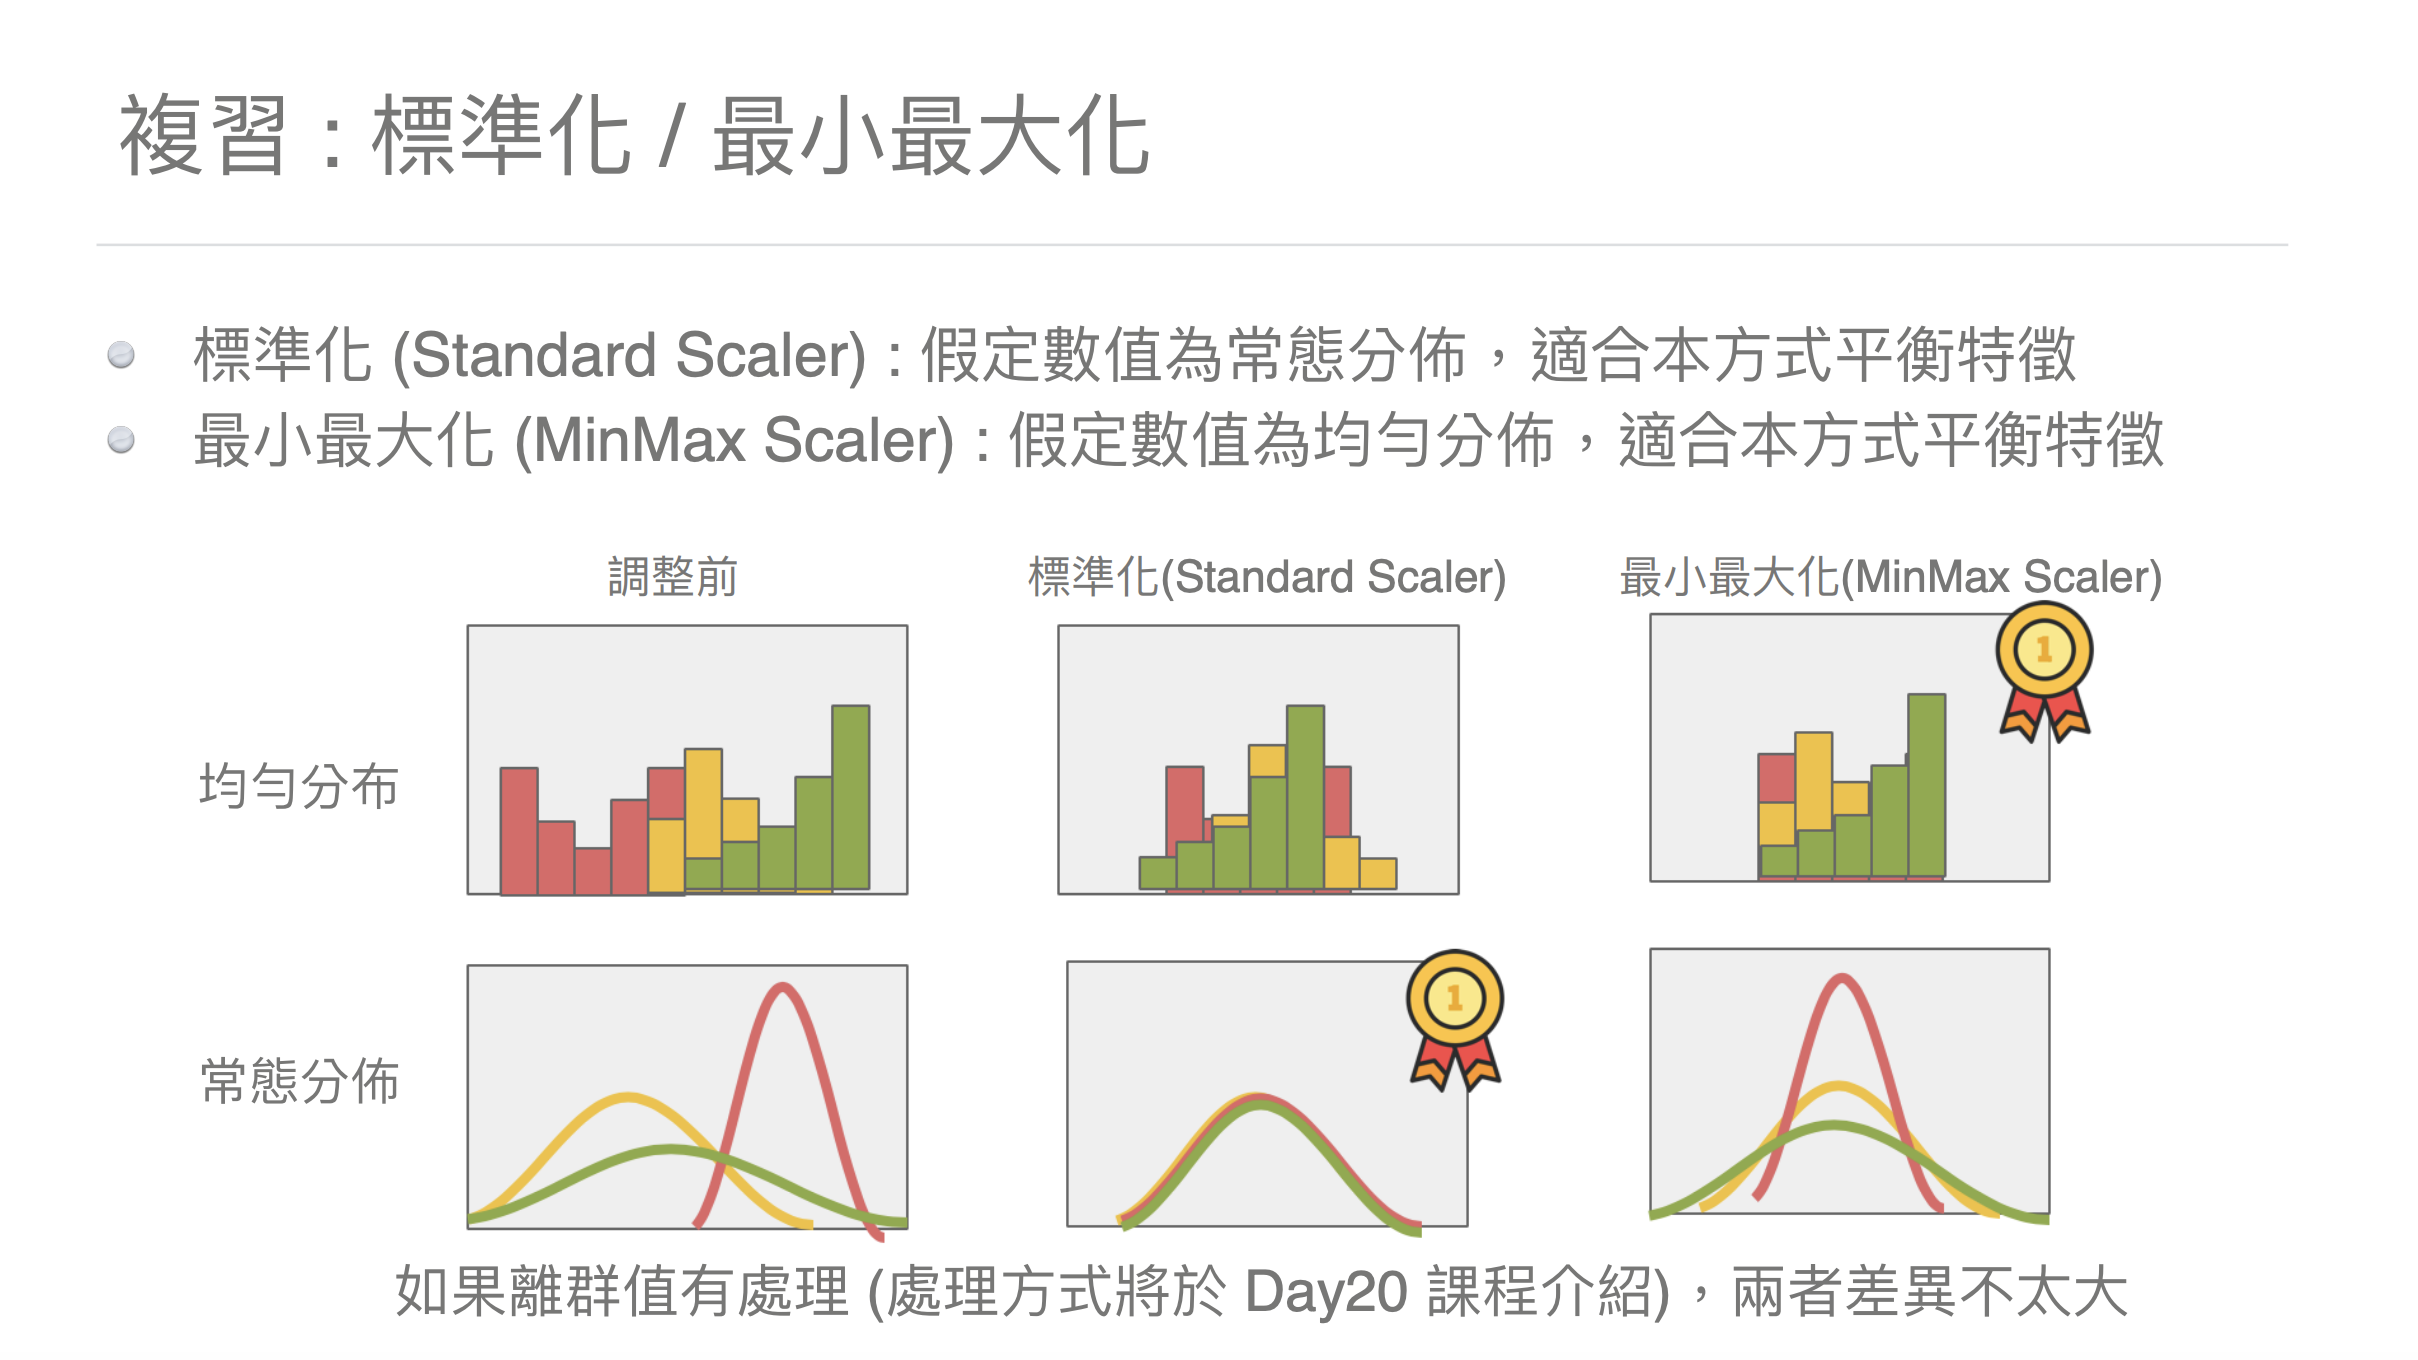

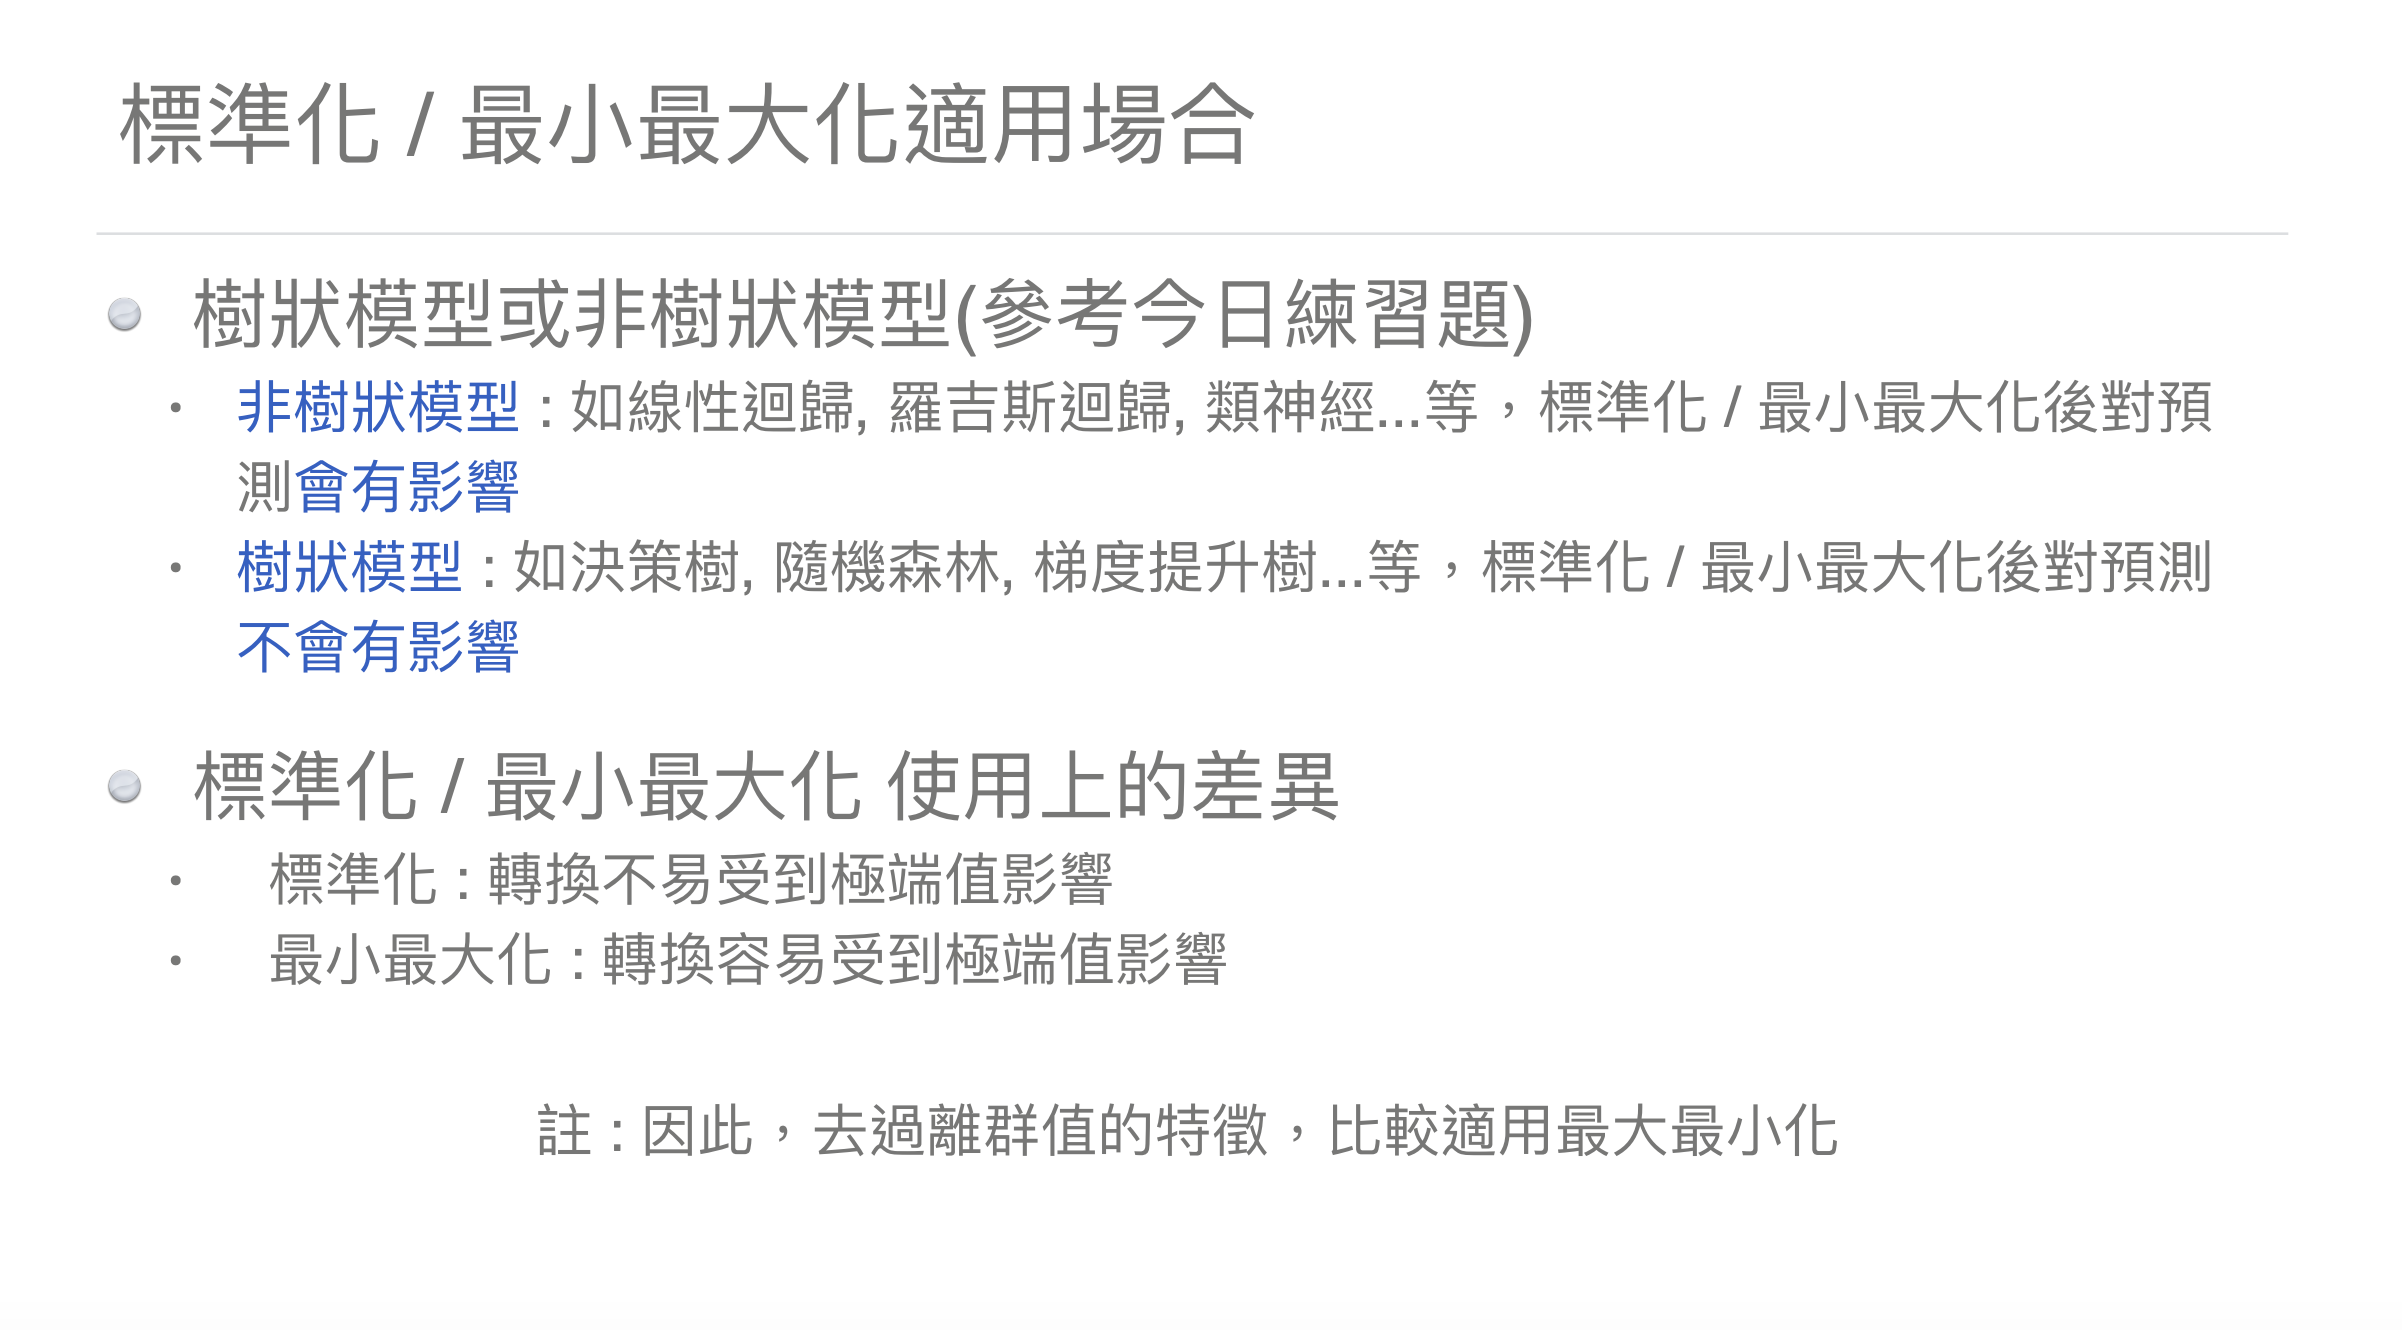

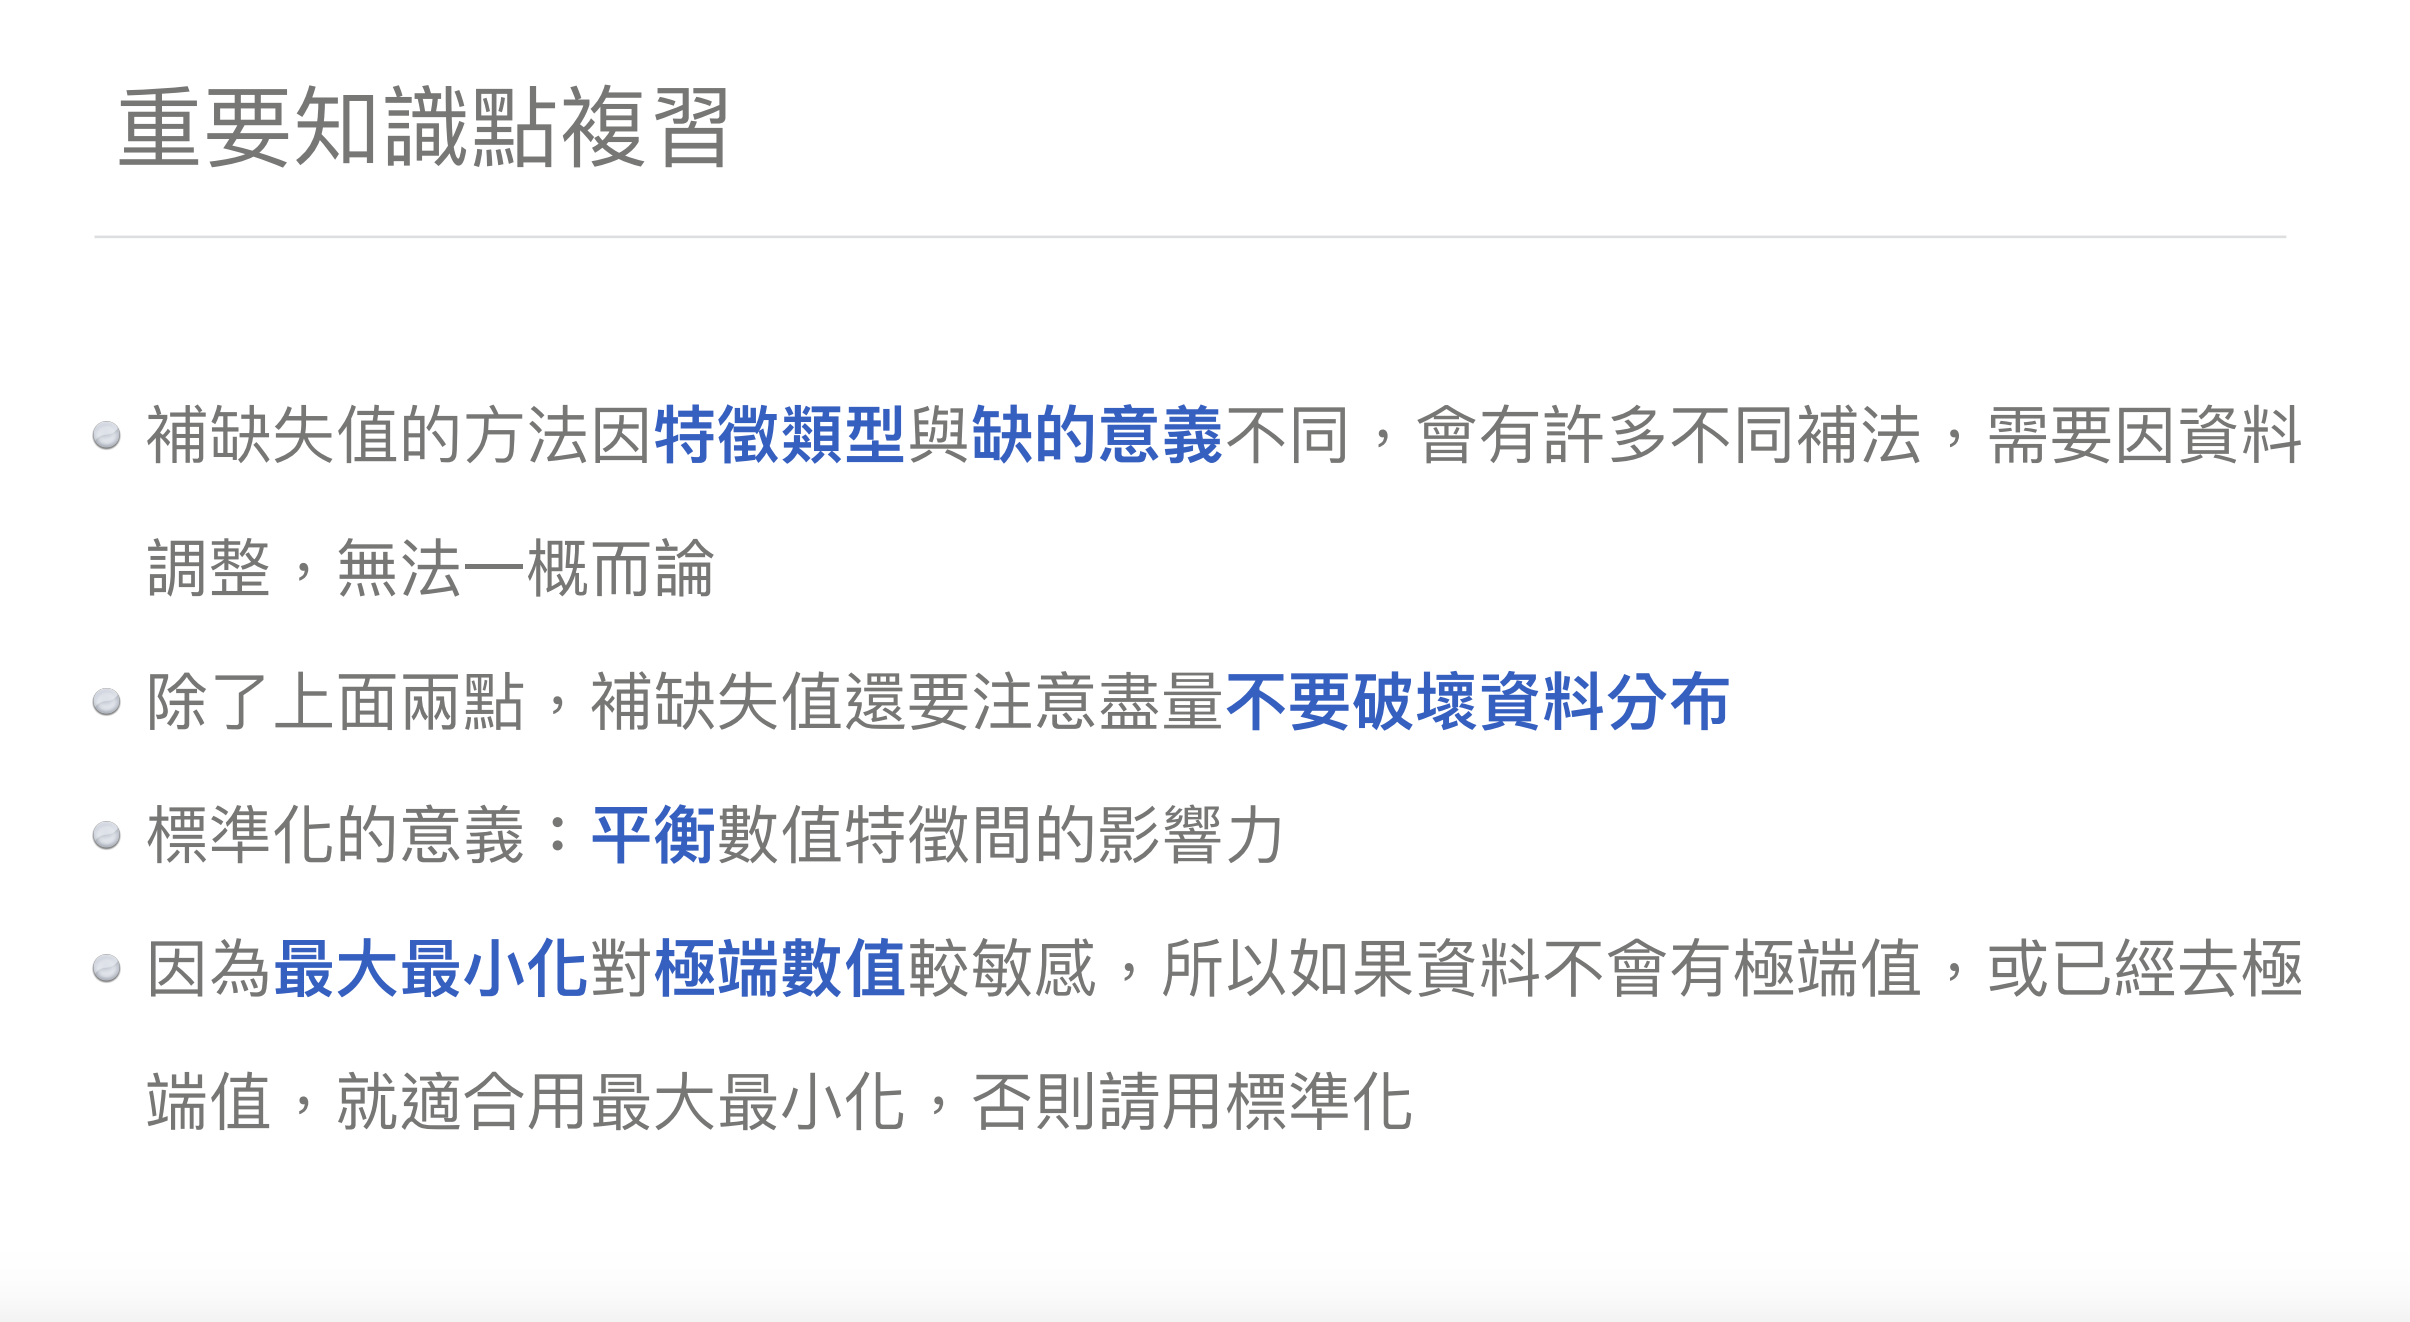